In [1]:
# local imports
import glob
from importlib import reload
from my_ddsp_utils import *
import ddsp
import ddsp.training

import time
import tensorflow_datasets as tfds


tf version:  2.1.0


### Build tfrecords! 

In [2]:
input_audio_filepatterns = "./Data/piano/piano30s.wav"
output_tfrecord_path = './Data/piano/piano30s.tfrecord'
train_file_pattern = output_tfrecord_path+"*"

input_audio_filepatterns

if not glob.glob(input_audio_filepatterns):
    raise ValueError('No audio files found. Please use the previous cell to '
                    'upload.')
else:
    print("found", input_audio_filepatterns)

!ddsp_prepare_tfrecord \
  --input_audio_filepatterns=$input_audio_filepatterns \
  --output_tfrecord_path=$output_tfrecord_path \
  --num_shards=10 \
  --alsologtostderr

found ./Data/piano/piano30s.wav
Instructions for updating:
non-resource variables are not supported in the long term
I0218 12:16:48.446970 4576056768 fn_api_runner_transforms.py:490] ==================== <function annotate_downstream_side_inputs at 0x7fa9eb8db620> ====================
I0218 12:16:48.448128 4576056768 fn_api_runner_transforms.py:490] ==================== <function fix_side_input_pcoll_coders at 0x7fa9eb8db730> ====================
I0218 12:16:48.448930 4576056768 fn_api_runner_transforms.py:490] ==================== <function lift_combiners at 0x7fa9eb8db7b8> ====================
I0218 12:16:48.449234 4576056768 fn_api_runner_transforms.py:490] ==================== <function expand_sdf at 0x7fa9eb8db840> ====================
I0218 12:16:48.449673 4576056768 fn_api_runner_transforms.py:490] ==================== <function expand_gbk at 0x7fa9eb8db8c8> ====================
I0218 12:16:48.450812 4576056768 fn_api_runner_transforms.py:490] ==================== <function sink

### build dataset by reading tfrecords!

In [3]:
data_provider = ddsp.training.data.TFRecordProvider(train_file_pattern)
dataset = data_provider.get_dataset(shuffle=False)

try:
    samples = list(iter(dataset))
    samples[0]
except tf.errors.OutOfRangeError:
    print("yup no")

In [4]:
batch = next(tfds.as_numpy(dataset))
audio = batch["audio"]

### Visualize an example!

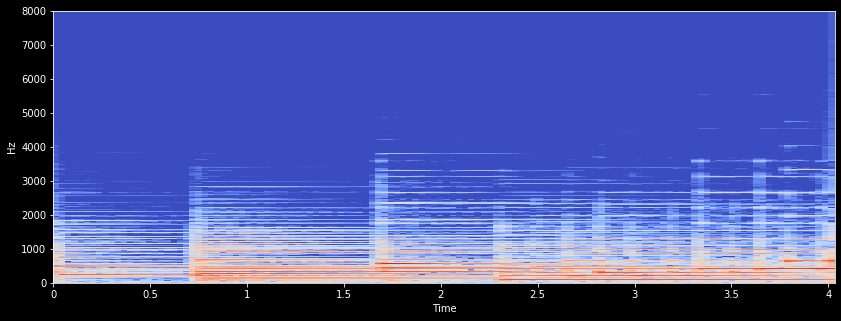

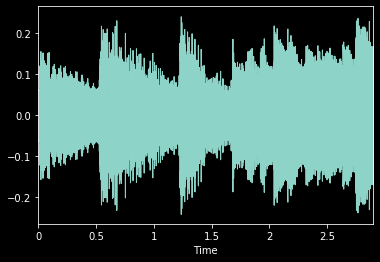

In [5]:
audio = samples[14]["audio"]
specPlot(audio)
wavePlot(audio)
play(audio)

### Define model

In [6]:
tf.reset_default_graph()
preprocessing = ddsp.training.preprocessing
encoders = ddsp.training.encoders
decoders = ddsp.training.decoders
models = ddsp.training.models
TIME_STEPS = 1000

In [7]:
# Create Neural Networks.
preprocessor = preprocessing.DefaultPreprocessor(time_steps=TIME_STEPS)

decoder = decoders.RnnFcDecoder(rnn_channels = 256,
                                rnn_type = 'gru',
                                ch = 256,
                                layers_per_stack = 1,
                                output_splits = (('amps', 1),
                                                 ('harmonic_distribution', 20),
                                                 ('noise_magnitudes', 20)))


In [8]:
# Create Processors.
n_samples = audio.shape[0]
additive = ddsp.synths.Additive(n_samples=n_samples, 
                                sample_rate=sample_rate,
                                name='additive')


In [9]:
# Gradually fade in noise during training for this example.
# Not required when training on whole dataset as batch variations help avoid
# local minima (only noise and no harmonic components).
noise_fade_fn = lambda: ddsp.training.nn.exp_fade(iter_start=0, 
                                                  iter_end=100, 
                                                  start_value=1e-5)

In [10]:
noise = ddsp.synths.FilteredNoise(window_size=0,
                                  name='noise')

In [11]:


add = ddsp.processors.Add(name='add')

# Create ProcessorGroup.
dag = [(additive, ['amps', 'harmonic_distribution', 'f0_hz']),
       (noise, ['noise_magnitudes']),
       (add, ['noise/signal', 'additive/signal'])]

processor_group = ddsp.processors.ProcessorGroup(dag=dag,
                                                 name='processor_group')


# Loss_functions
spectral_loss = ddsp.losses.SpectralLoss(loss_type='L1',
                                         mag_weight=1.0,
                                         logmag_weight=1.0)

# Put it together in a model.
model = models.Autoencoder(preprocessor=preprocessor,
                           encoder=None,
                           decoder=decoder,
                           processor_group=processor_group,
                           losses=[spectral_loss])

### NEW MODEL

In [71]:
# define strategy
strategy = ddsp.training.train_util.get_strategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [75]:
TIME_STEPS = 1000

# Create Neural Networks.
preprocessor = preprocessing.DefaultPreprocessor(time_steps=TIME_STEPS)

decoder = decoders.RnnFcDecoder(rnn_channels = 256,
                                rnn_type = 'gru',
                                ch = 256,
                                layers_per_stack = 1,
                                output_splits = (('amps', 1),
                                                 ('harmonic_distribution', 45),
                                                 ('noise_magnitudes', 45)))

# Create Processors.
additive = ddsp.synths.Additive(n_samples=n_samples, 
                                sample_rate=sample_rate,
                                name='additive')

noise = ddsp.synths.FilteredNoise(window_size=0,
                                  initial_bias=-10.0,
                                  name='noise')
add = ddsp.processors.Add(name='add')

# Create ProcessorGroup.
dag = [(additive, ['amps', 'harmonic_distribution', 'f0_hz']),
       (noise, ['noise_magnitudes']),
       (add, ['noise/signal', 'additive/signal'])]

processor_group = ddsp.processors.ProcessorGroup(dag=dag,
                                                 name='processor_group')


# Loss_functions
spectral_loss = ddsp.losses.SpectralLoss(loss_type='L1',
                                         mag_weight=1.0,
                                         logmag_weight=1.0)

with strategy.scope():
    # Put it together in a model.
    model = models.Autoencoder(preprocessor=preprocessor,
                             encoder=None,
                             decoder=decoder,
                             processor_group=processor_group,
                             losses=[spectral_loss])
    trainer = ddsp.training.train_util.Trainer(model, strategy, learning_rate=1e-3)

In [73]:
# Build model, easiest to just run forward pass.
dataset = trainer.distribute_dataset(dataset)
trainer.build(next(iter(dataset)))

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spectral_loss (SpectralLoss) multiple                  0         
_________________________________________________________________
rnn_fc_decoder (RnnFcDecoder multiple                  814171    
_________________________________________________________________
processor_group (ProcessorGr multiple                  0         
Total params: 814,171
Trainable params: 814,171
Non-trainable params: 0
_________________________________________________________________


###  Train

In [53]:
dataset = trainer.distribute_dataset(dataset)

In [55]:
trainer.build(next(iter(dataset)))

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spectral_loss (SpectralLoss) multiple                  0         
_________________________________________________________________
rnn_fc_decoder (RnnFcDecoder multiple                  801321    
_________________________________________________________________
processor_group (ProcessorGr multiple                  0         
Total params: 801,321
Trainable params: 801,321
Non-trainable params: 0
_________________________________________________________________


In [58]:
dataset_iter = iter(dataset)

In [59]:
losses = trainer.train_step(dataset_iter)

TypeError: in converted code:

    /Users/trippgordon/miniconda3/envs/ddsp/lib/python3.6/site-packages/ddsp/training/train_util.py:213 train_step  *
        losses = self.run(self.step_fn, batch)
    /Users/trippgordon/miniconda3/envs/ddsp/lib/python3.6/site-packages/ddsp/training/train_util.py:194 run  *
        return self.strategy.experimental_run_v2(fn, args=args, kwargs=kwargs)
    /Users/trippgordon/miniconda3/envs/ddsp/lib/python3.6/site-packages/tensorflow_core/python/distribute/distribute_lib.py:763 experimental_run_v2
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/trippgordon/miniconda3/envs/ddsp/lib/python3.6/site-packages/tensorflow_core/python/distribute/distribute_lib.py:1819 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/trippgordon/miniconda3/envs/ddsp/lib/python3.6/site-packages/tensorflow_core/python/distribute/mirrored_strategy.py:683 _call_for_each_replica
        return wrapped(args, kwargs)
    /Users/trippgordon/miniconda3/envs/ddsp/lib/python3.6/site-packages/tensorflow_core/python/eager/def_function.py:568 __call__
        result = self._call(*args, **kwds)
    /Users/trippgordon/miniconda3/envs/ddsp/lib/python3.6/site-packages/tensorflow_core/python/eager/def_function.py:599 _call
        return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable

    TypeError: 'NoneType' object is not callable
